<a href="https://colab.research.google.com/github/ImaduddinAhmedMohammed/ImaduddinAhmed_INFO5731_Spring2024/blob/main/Mohammed_Imad_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 Assignment 3**

In this assignment, we will delve into various aspects of natural language processing (NLP) and text analysis. The tasks are designed to deepen your understanding of key NLP concepts and techniques, as well as to provide hands-on experience with practical applications.

Through these tasks, you'll gain practical experience in NLP techniques such as N-gram analysis, TF-IDF, word embedding model creation, and sentiment analysis dataset creation.

**Expectations**:
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).


**Total points**: 100

**Deadline**: See Canvas

**Late Submission will have a penalty of 10% reduction for each day after the deadline.**


## Question 1 (30 points)

**Understand N-gram**

Write a python program to conduct N-gram analysis based on the dataset in your assignment two. You need to write codes from scratch instead of using any pre-existing libraries to do so:

(1) Count the frequency of all the N-grams (N=3).

(2) Calculate the probabilities for all the bigrams in the dataset by using the fomular count(w2 w1) / count(w2). For example, count(really like) / count(really) = 1 / 3 = 0.33.

(3) Extract all the noun phrases and calculate the relative probabilities of each review in terms of other reviews (abstracts, or tweets) by using the fomular frequency (noun phrase) / max frequency (noun phrase) on the whole dataset. Print out the result in a table with column name the all the noun phrases and row name as all the 100 reviews (abstracts, or tweets).

In [ ]:
import pandas as pd

file_path = 'clean_csv_file_path.csv'
data = pd.read_csv(file_path)


def generate_n_grams(words, n=3):
    n_grams = [' '.join(words[i:i+n]) for i in range(len(words) - n + 1)]
    return n_grams

def calculate_bigram_probabilities(n_grams):
    bigram_frequencies = {}
    for n_gram in n_grams:
        words = n_gram.split()
        bigram = ' '.join(words[:2])
        if bigram in bigram_frequencies:
            bigram_frequencies[bigram] += 1
        else:
            bigram_frequencies[bigram] = 1

    word_frequencies = {}
    for bigram in bigram_frequencies:
        word = bigram.split()[0]
        if word in word_frequencies:
            word_frequencies[word] += bigram_frequencies[bigram]
        else:
            word_frequencies[word] = bigram_frequencies[bigram]

    bigram_probabilities = {bigram: bigram_frequencies[bigram] / word_frequencies[bigram.split()[0]] for bigram in bigram_frequencies}
    return bigram_probabilities


n_gram_counts = {}
n_grams_total = []

# Generate trigrams for each review and count frequencies
for review in data['Cleaned User Review']:
    words = review.split()
    n_grams = generate_n_grams(words, 3)
    n_grams_total.extend(n_grams)
    for n_gram in n_grams:
        if n_gram in n_gram_counts:
            n_gram_counts[n_gram] += 1
        else:
            n_gram_counts[n_gram] = 1

bigram_probabilities = calculate_bigram_probabilities(n_grams_total)

def extract_noun_phrases(words):
    # noun phrase extraction based on simple heuristics
    noun_phrases = []
    current_phrase = []
    for word in words:
        if word.lower() not in ['is', 'are', 'was', 'were', 'can', 'could', 'will', 'would', 'should', 'has', 'have', 'had', 'do', 'does', 'did', 'to', 'at', 'in', 'out', 'on', 'off', 'over', 'under', 'and', 'or', 'but']:
            current_phrase.append(word)
        elif current_phrase:
            noun_phrases.append(' '.join(current_phrase))
            current_phrase = []
    if current_phrase:  # Catch any remaining words in the last phrase
        noun_phrases.append(' '.join(current_phrase))
    return noun_phrases

# Process each review
noun_phrase_frequencies = {}
for index, review in enumerate(data['Cleaned User Review']):
    words = review.split()
    noun_phrases = extract_noun_phrases(words)
    for phrase in noun_phrases:
        if phrase not in noun_phrase_frequencies:
            noun_phrase_frequencies[phrase] = [0] * len(data)
        noun_phrase_frequencies[phrase][index] += 1

# Calculate relative probabilities
for phrase, frequencies in noun_phrase_frequencies.items():
    max_frequency = max(frequencies)
    noun_phrase_frequencies[phrase] = [freq / max_frequency for freq in frequencies]

# Convert to DataFrame for easy viewing
df_noun_phrases = pd.DataFrame(noun_phrase_frequencies)
df_noun_phrases.columns.name = "Noun Phrases"
df_noun_phrases.index.name = "Review"

# Display the first few rows to check
#print(df_noun_phrases.head())

print("The Count frequency of the N-grams is:\n")
print(sorted(n_gram_counts.items(), key=lambda x: x[1], reverse=True)[:10])
print("\nThe bigram probabilities are:\n")
print(sorted(bigram_probabilities.items(), key=lambda x: x[1], reverse=True)[:10])

df_noun_phrases.to_csv('noun_phrase_probabilities.csv', index=True)



Noun Phrases  youll wit brain fully switched watching oppenheimer  \
Review                                                              
0                                                           1.0     
1                                                           0.0     
2                                                           0.0     
3                                                           0.0     
4                                                           0.0     

Noun Phrases  easily get away nonattentive viewer intelligent filmmaking show audience great respect fire dialogue packed information relentless pace jump different time oppenheimer life continuously hour runtime visual clue guide viewer time youll get grip quite quickly relentlessness help express urgency u attacked chase atomic bomb germany  \
Review                                                                                                                                                                  

## Question 2 (25 points)

**Undersand TF-IDF and Document representation**

Starting from the documents (all the reviews, or abstracts, or tweets) collected for assignment two, write a python program:

(1) To build the documents-terms weights (tf * idf) matrix.

(2) To rank the documents with respect to query (design a query by yourself, for example, "An Outstanding movie with a haunting performance and best character development") by using cosine similarity.

Note: You need to write codes from scratch instead of using any pre-existing libraries to do so.

In [8]:
# Write your code here
import pandas as pd
from collections import defaultdict
import math

file_path = 'clean_csv_file_path.csv'
data = pd.read_csv(file_path)

data.head()


# Extract the 'Cleaned User Review' column as our corpus
documents = data['Cleaned User Review'].tolist()

# Function to tokenize documents
def tokenize(doc):
    return doc.split()

# Tokenize each document
tokenized_documents = [tokenize(doc) for doc in documents]

# Calculate TF (Term Frequency)
def calculate_tf(tokenized_doc):
    tf_dict = defaultdict(int)
    for word in tokenized_doc:
        tf_dict[word] += 1
    # Normalize by the total number of words in the document
    total_words = len(tokenized_doc)
    for word in tf_dict:
        tf_dict[word] = tf_dict[word] / total_words
    return tf_dict

# Calculate IDF (Inverse Document Frequency)
def calculate_idf(tokenized_docs):
    idf_dict = defaultdict(int)
    total_docs = len(tokenized_docs)
    for doc in tokenized_docs:
        # Use set to count each word in each document only once
        for word in set(doc):
            idf_dict[word] += 1
    for word in idf_dict:
        # Apply IDF formula
        idf_dict[word] = math.log(total_docs / idf_dict[word]) + 1  # Adding 1 to avoid division by zero
    return idf_dict

# Calculate TF for each document
tf_documents = [calculate_tf(doc) for doc in tokenized_documents]

# Calculate IDF across all documents
idf_documents = calculate_idf(tokenized_documents)

# Function to calculate TF-IDF for each document
def calculate_tf_idf(tf_docs, idf_docs):
    tf_idf = []
    for doc_tf in tf_docs:
        doc_tf_idf = {}
        for word, value in doc_tf.items():
            doc_tf_idf[word] = value * idf_docs[word]
        tf_idf.append(doc_tf_idf)
    return tf_idf

# Calculate TF-IDF matrix
tf_idf_matrix = calculate_tf_idf(tf_documents, idf_documents)


# Function to calculate the dot product of two vectors
def dot_product(vector1, vector2):
    return sum([vector1.get(word, 0) * vector2.get(word, 0) for word in vector1])

# Function to calculate the norm (magnitude) of a vector
def vector_norm(vector):
    return math.sqrt(sum([value**2 for value in vector.values()]))

# Function to calculate cosine similarity between two vectors
def cosine_similarity(vector1, vector2):
    return dot_product(vector1, vector2) / (vector_norm(vector1) * vector_norm(vector2))

# Preprocess and tokenize the query
query = "An Outstanding movie with a haunting performance and best character development"
tokenized_query = tokenize(query.lower())

# Calculate TF for the query
tf_query = calculate_tf(tokenized_query)

# Calculate TF-IDF for the query using the already calculated IDF for documents
tf_idf_query = {word: tf_query[word] * idf_documents.get(word, 0) for word in tf_query}

# Calculate cosine similarity for each document
cosine_similarities = []
for doc in tf_idf_matrix:
    cosine_similarities.append(cosine_similarity(tf_idf_query, doc))

# Rank the documents based on cosine similarity
ranked_doc_indices = sorted(range(len(cosine_similarities)), key=lambda i: cosine_similarities[i], reverse=True)

# Display the top 5 ranked documents
print("Top 5 ranked documents:")
for i in range(5):
    index = ranked_doc_indices[i]
    print(f"Document {index + 1} (Index: {index}), Cosine Similarity: {cosine_similarities[index]}")

# Display TF-IDF matrix for the first document
tf_idf_matrix[0]




Top 5 ranked documents:
Document 77 (Index: 76), Cosine Similarity: 0.14051232264062152
Document 79 (Index: 78), Cosine Similarity: 0.11441327270835107
Document 22 (Index: 21), Cosine Similarity: 0.10883341568730721
Document 14 (Index: 13), Cosine Similarity: 0.10854375340244243
Document 21 (Index: 20), Cosine Similarity: 0.10210888815594973


{'youll': 0.07442459099133555,
 'wit': 0.04246341049990979,
 'brain': 0.03027069904207569,
 'fully': 0.026710065487183757,
 'switched': 0.034140590131211984,
 'watching': 0.02194787867337789,
 'oppenheimer': 0.01951033443108759,
 'could': 0.03289671184095371,
 'easily': 0.02772166694646044,
 'get': 0.03615597516848319,
 'away': 0.026710065487183757,
 'nonattentive': 0.04246341049990979,
 'viewer': 0.05342013097436751,
 'intelligent': 0.026710065487183757,
 'filmmaking': 0.02581776976251418,
 'show': 0.02056665475827217,
 'audience': 0.020157054597133718,
 'great': 0.031497116081392884,
 'respect': 0.03196118049142577,
 'fire': 0.03721229549566778,
 'dialogue': 0.02056665475827217,
 'packed': 0.03027069904207569,
 'information': 0.028889475126969974,
 'relentless': 0.07442459099133555,
 'pace': 0.03196118049142577,
 'jump': 0.022470551942218434,
 'different': 0.021458950482941743,
 'time': 0.03550270268530775,
 'life': 0.01721943693797642,
 'continuously': 0.03721229549566778,
 'hour': 

## Question 3 (25 points)

**Create your own word embedding model**

Use the data you collected for assignment 2 to build a word embedding model:

(1) Train a 300-dimension word embedding (it can be word2vec, glove, ulmfit, bert, or others).

(2) Visualize the word embedding model you created.

Reference: https://machinelearningmastery.com/develop-word-embeddings-python-gensim/

Reference: https://jaketae.github.io/study/word2vec/

In [9]:
!pip install --upgrade gensim

Word2Vec<vocab=4230, vector_size=300, alpha=0.025>
['movie', 'oppenheimer', 'film', 'nolan', 'one', 'time', 'like', 'bomb', 'robert', 'character', 'story', 'murphy', 'scene', 'good', 'best', 'work', 'much', 'hour', 'christopher', 'world', 'really', 'also', 'nolans', 'life', 'see', 'long', 'many', 'actor', 'great', 'atomic', 'history', 'first', 'feel', 'would', 'way', 'well', 'cillian', 'performance', 'even', 'get', 'downey', 'man', 'could', 'war', 'watch', 'make', 'cast', 'acting', 'jr', 'part', 'people', 'year', 'event', 'u', 'sound', 'dont', 'know', 'audience', 'never', 'ever', 'imax', 'end', 'blunt', 'role', 'score', 'something', 'director', 'every', 'j', 'thing', 'oscar', 'doesnt', 'show', 'point', 'say', 'im', 'emily', 'seen', 'back', 'found', 'take', 'think', 'need', 'still', 'historical', 'two', 'give', 'screen', 'lot', 'scientist', 'made', 'project', 'moment', 'cinema', 'effect', 'going', 'test', 'damon', 'interesting', 'act', 'strauss', 'bit', 'quite', 'without', 'big', 'flore

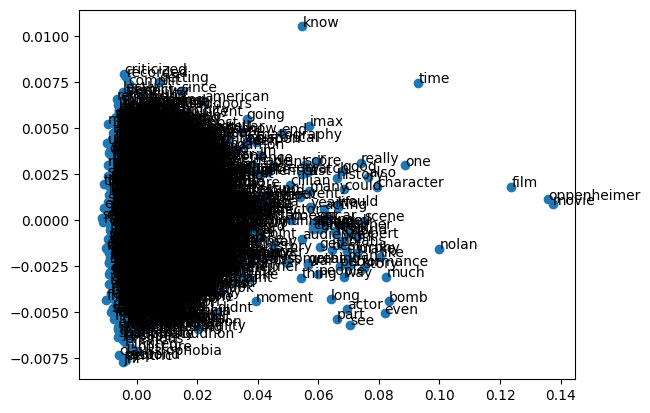

In [26]:
import pandas as pd
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot

data=pd.read_csv('clean_csv_file_path.csv')
sentences = [row['Cleaned User Review'].split() for index, row in data.iterrows()]

model=Word2Vec(sentences, vector_size=300, window=5, min_count=1, workers=4)
print(model)
# summarize vocabulary
words = list(model.wv.key_to_index)
print(words)
# access vector for one word
#print(model['brain'])
# save model
model.save('model.bin')
# load model
new_model = Word2Vec.load('model.bin')
print(f"\n",new_model)
# fit a 2d PCA model to the vectors
X = model.wv.vectors
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
words = list(model.wv.key_to_index.keys())
for i, word in enumerate(words):
 pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

## Question 4 (20 Points)

**Create your own training and evaluation data for sentiment analysis.**

 **You don't need to write program for this question!**

 For example, if you collected a movie review or a product review data, then you can do the following steps:

*   Read each review (abstract or tweet) you collected in detail, and annotate each review with a sentiment (positive, negative, or neutral).

*   Save the annotated dataset into a csv file with three columns (first column: document_id, clean_text, sentiment), upload the csv file to GitHub and submit the file link blew.

*   This datset will be used for assignment four: sentiment analysis and text classification.


In [ ]:
# The GitHub link of your final csv file


# Link: https://github.com/ImaduddinAhmedMohammed/ImaduddinAhmed_INFO5731_Spring2024/blob/f777e2d50502761a37fb92752e824b2cb501fabd/sentiment_analysis_movie_review.xlsx



# Mandatory Question

Provide your thoughts on the assignment. What did you find challenging, and what aspects did you enjoy? Your opinion on the provided time to complete the assignment.

In [ ]:
# Type your answer